# Incident Impact Predictions 

## 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score

from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
pd.set_option('max_rows', 100)
pd.set_option('max_columns', None)

In [3]:
#sns.set_context("notebook", font_scale=0.8)
#%matplotlib notebook

## 2.Load data

In [4]:
incident_df = pd.read_csv('incident_event_log.csv')

In [5]:
incident_df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


### 2.1 Data understanding

In [6]:
incident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [7]:
incident_df1 = incident_df.copy() # Copy of original dataframe for EDA 

# Replace all '?' with np.nan
incident_df1 = incident_df1.replace(to_replace='?', value=np.nan)

# Null values by column:
null_val_sumry = pd.DataFrame(incident_df1.isna().sum()).reset_index()
null_val_sumry.columns = ['col_name', 'null_vals']
null_val_sumry['perc_null_vals'] = null_val_sumry['null_vals'].apply(lambda x: round((x/len(incident_df1))*100))

In [8]:
null_val_cols = null_val_sumry[null_val_sumry['perc_null_vals']>0]
null_val_cols

,col_name,null_vals,perc_null_vals
8,opened_by,4835,3
10,sys_created_by,53076,37
11,sys_created_at,53076,37
18,u_symptom,32964,23
19,cmdb_ci,141267,100
23,assignment_group,14213,10
24,assigned_to,27496,19
28,problem_id,139417,98
29,rfc,140721,99
30,vendor,141468,100


In [9]:
# Total null values.
incident_df1.isna().sum().sum()

894597

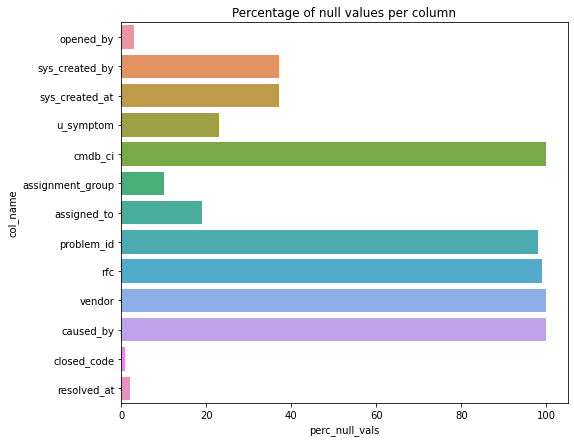

In [10]:
# Visualizing the null values.
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(y='col_name', x='perc_null_vals', data=null_val_cols, ax=ax) 
plt.title('Percentage of null values per column')
plt.show()

In [11]:
# cols = incident_df1.columns 
# colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue - not missing.
# fig, ax = plt.subplots(figsize=(8,6))
# sns.heatmap(incident_df1[cols].isnull(),cmap=sns.color_palette(colours), ax=ax, xticklabels=True, yticklabels=False)
# plt.show()

# Note: This cell crashes in normal mode but works when we set %matplotlib notebook

#### 2.1.1 Observations
- 141712  and 36 Data columns.
- Mixture of categorical, numeric and timestamp(recorded as object)
- null values recorded as '?' and '-100'.

## 3. EDA

### 3.1 Dataset details

In [12]:
col_list1 = incident_df1.columns

# Count the no of numeric columns.
numeric = [col for col in col_list1 if (incident_df1[col].dtypes == 'int64')]

# boolean columns
bool_cols = ['active', 'made_sla', 'knowledge', 'u_priority_confirmation', 'notify']

# Count the categorical columns.
categorical_all = [col for col in col_list1 if incident_df1[col].dtypes != 'int64']

## list of datetime columns.
datetime_all = ['opened_at', 'sys_created_at', 'sys_updated_at', 'resolved_at', 'closed_at']

categorical_filt = [col for col in categorical_all if col not in datetime_all]
cat1 = [col for col in categorical_filt if col not in bool_cols]

columns_summary = {'Numeric columns':len(numeric),
                   'Boolean columns':len(bool_cols),
                   'Categorical columns':len(cat1),
                   'Datetime columns': len(datetime_all)}

In [13]:
#unique_val_dict
columns_summary_df = pd.concat([pd.Series(columns_summary.keys()),
                                pd.Series(columns_summary.values())],
                                axis=1)
columns_summary_df.columns = ['column type', 'No. of columns']

In [14]:
incident_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141683 non-null  object
 8   opened_by                136877 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           88636 non-null   object
 11  sys_created_at           88636 non-null   object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [15]:
columns_summary_df

,column type,No. of columns
0,Numeric columns,3
1,Boolean columns,5
2,Categorical columns,23
3,Datetime columns,5


### 3.2 Data preprocessing | Visualizations 

#### 3.2.1 Handling null values

In [16]:
# Function to remove all null columns(EDA)
def null_value_remove(Xdf):
    # Replace all '?' with np.nan
    Xdf = Xdf.replace(to_replace='?', value=np.nan)
    Xdf['incident_state'] = Xdf['incident_state'].replace('-100', np.nan)
    
    # Delete all columns with more than 20% null values.
    del_cols = ['cmdb_ci', 'problem_id', 'rfc', 'vendor', 'caused_by', 'sys_created_by', 'sys_created_at'] 
    Xdf = Xdf.drop(del_cols, axis=1)
    
    return Xdf    

In [17]:
# Function to impute with mode values (EDA/Feature engineering)
def null_value_impute(Xdf):
    Xdf['caller_id'] = Xdf['caller_id'].fillna(value=Xdf['caller_id'].mode()[0])
    Xdf['opened_by'] = Xdf['opened_by'].fillna(value=Xdf['opened_by'].mode()[0])
    Xdf['location'] = Xdf['location'].fillna(value=Xdf['location'].mode()[0])
    Xdf['category'] = Xdf['category'].fillna(value=Xdf['category'].mode()[0])
    Xdf['subcategory']= Xdf['subcategory'].fillna(value=Xdf['subcategory'].mode()[0])
    Xdf['u_symptom'] = Xdf['u_symptom'].fillna(value=Xdf['u_symptom'].mode()[0])
    Xdf['assignment_group'] = Xdf['assignment_group'].fillna(value=Xdf['assignment_group'].mode()[0])
    Xdf['assigned_to'] = Xdf['assigned_to'].fillna(value=Xdf['assigned_to'].mode()[0])
    Xdf['resolved_by'] = Xdf['resolved_by'].fillna(value=Xdf['resolved_by'].mode()[0])
    
    # Wherever there are null values, pad them(substitute them) with the previous nun null value. 
    Xdf['closed_code'] = Xdf['closed_code'].fillna(method='pad')
    
    # Replace the null values in 'incident_state' with most frequent value (mode).
    #replace_val = 'Active' #Xdf['incident_state'].mode()[0] - hardcoded for simplicity. Fix this later
    Xdf['incident_state'] = Xdf['incident_state'].fillna(value=Xdf['incident_state'].mode()[0]) 
    
    return Xdf

#### 3.2.2 Encoding boolean features

In [18]:
# Function to encode the boolean features (EDA/model building)
def boolean_encoder(Xdf):
    Xdf['active'] = Xdf['active'].apply(lambda x:1 if x==True else 0)
    Xdf['made_sla'] = Xdf['made_sla'].apply(lambda x:1 if x==True else 0)
    Xdf['knowledge'] = Xdf['knowledge'].apply(lambda x:1 if x==True else 0)
    Xdf['u_priority_confirmation'] = Xdf['u_priority_confirmation'].apply(lambda x:1 if x==True else 0)
    Xdf['notify'] = Xdf['notify'].apply(lambda x:1 if x=='Send Email' else 0)
    
    return Xdf
#convert true false values as 0,1

In [19]:
incident_df1 = null_value_remove(incident_df1)
incident_df1 = null_value_impute(incident_df1)
incident_df1 = boolean_encoder(incident_df1)

####   3.2.3 Visualizing numeric columns

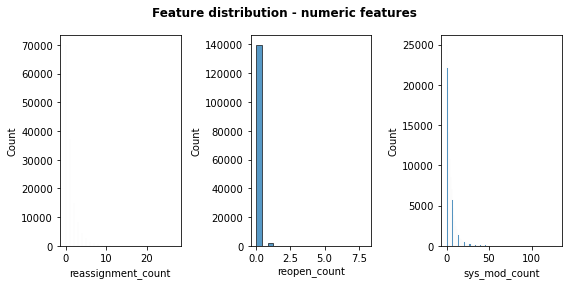

In [20]:
fig, axes = plt.subplots(1, 3 , figsize=(8,4))  
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.histplot(data=incident_df1, x=incident_df1[numeric[idx]], ax=ax)

fig.suptitle('Feature distribution - numeric features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

####  3.2.4 Visualizing boolean columns

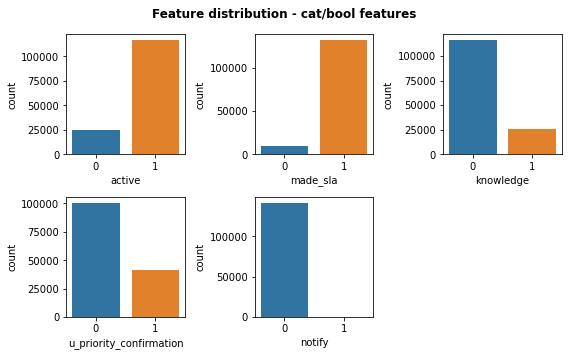

In [21]:
fig, axes = plt.subplots(2,3, figsize=(8,5)) #figsize=(4,4)
fig.delaxes(axes[1,2])
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < 5:
        sns.countplot(data=incident_df1, x=incident_df1[bool_cols[idx]], ax=ax)

fig.suptitle('Feature distribution - cat/bool features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

####  3.2.5 understanding categorical features

In [22]:
datetime_cols = ['opened_at', 'sys_updated_at', 'resolved_at', 'closed_at']
# Note: 'sys_created_at' was deleted due to presence of null vals

In [23]:
datetime_cols = ['opened_at', 'sys_updated_at', 'resolved_at', 'closed_at']
# Note: 'sys_created_at' was deleted due to presence of null vals
num_bool_dt = numeric + bool_cols + datetime_cols
cat_cols = [col for col in incident_df1.columns if col not in num_bool_dt]

In [24]:
unique_val_dict = dict.fromkeys(cat_cols)
for key in cat_cols:
    unique_val_dict[key] = len(incident_df1[key].unique())    

In [25]:
#unique_val_dict
unique_df = pd.concat([pd.Series(unique_val_dict.keys()),
                       pd.Series(unique_val_dict.values())],
                       axis=1)
unique_df.columns = ['columns', 'num_unique_vals']

In [26]:
unique_df

,columns,num_unique_vals
0,number,24918
1,incident_state,8
2,caller_id,5244
3,opened_by,207
4,sys_updated_by,846
5,contact_type,5
6,location,224
7,category,58
8,subcategory,254
9,u_symptom,525


In [27]:
# All cols with less than 100 unique values will be visualized.
unique_df[unique_df['num_unique_vals']< 100]

,columns,num_unique_vals
1,incident_state,8
5,contact_type,5
7,category,58
10,impact,3
11,urgency,3
12,priority,4
13,assignment_group,78
15,closed_code,17


In [28]:
# All cols with more than 100 unique values - Very high cardinality features.
unique_df[unique_df['num_unique_vals'] > 100]

,columns,num_unique_vals
0,number,24918
2,caller_id,5244
3,opened_by,207
4,sys_updated_by,846
6,location,224
8,subcategory,254
9,u_symptom,525
14,assigned_to,234
16,resolved_by,216


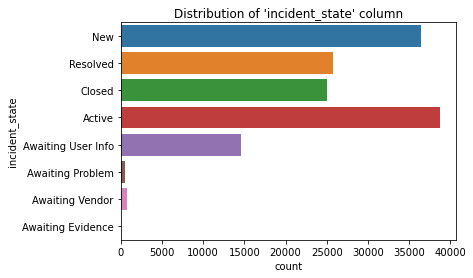

In [29]:
fig, ax = plt.subplots()  #visualization of <100 unique values col
sns.countplot(data=incident_df1, y=incident_df1['incident_state'], ax=ax)
plt.title("Distribution of 'incident_state' column")
plt.show()

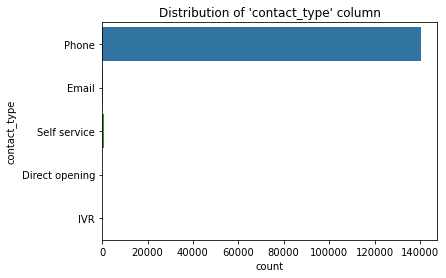

In [30]:
fig, ax = plt.subplots()
sns.countplot(data=incident_df1, y=incident_df1['contact_type'], ax=ax)
plt.title("Distribution of 'contact_type' column")
plt.show()

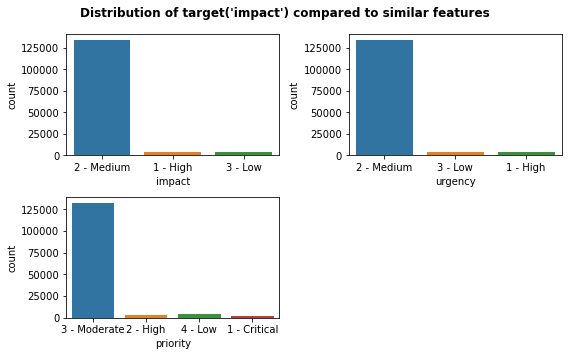

In [31]:
#compare the target col with similer feachers
fig, ax = plt.subplots(2,2, figsize=(8,5))   
fig.delaxes(ax[1,1])
ax = ax.flatten()

sns.countplot(data=incident_df1, x=incident_df1['impact'], ax=ax[0])
sns.countplot(data=incident_df1, x=incident_df1['urgency'], ax=ax[1])
sns.countplot(data=incident_df1, x=incident_df1['priority'], ax=ax[2])

fig.suptitle("Distribution of target('impact') compared to similar features", ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

In [32]:
# Summary statistics for categorical columns.
incident_df1[cat_cols].describe(include=['O'])

,number,incident_state,caller_id,opened_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,closed_code,resolved_by
count,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712,141712
unique,24918,8,5244,207,846,5,224,58,254,525,3,3,4,78,234,17,216
top,INC0019396,Active,Caller 1904,Opened by 17,Updated by 908,Phone,Location 204,Category 26,Subcategory 174,Symptom 491,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 17,code 6,Resolved by 15
freq,58,38721,1454,46301,36162,140462,31766,18531,35896,84949,134335,134094,132452,57687,38086,86996,15647


#### 3.2.6 Encoding categorical features

In [33]:
# Function to encode categorical columns with high cardinality (EDA/Feature engineering)
def categorical_encoder(Xdf):
    # scale:
    urgency_scale = {'1 - High':1, '2 - Medium':2, '3 - Low':3}
    priority_scale = {'1 - Critical':1, '2 - High':2, '3 - Moderate':3, '4 - Low':4}
    
    Xdf['urgency'] = Xdf['urgency'].map(urgency_scale)
    Xdf['priority'] = Xdf['priority'].map(priority_scale)
    
    Xdf['number'] = Xdf['number'].apply(lambda x: x.strip('INC')).astype('int')
    Xdf['opened_by'] = Xdf['opened_by'].apply(lambda x: x.strip('Openedby ')).astype('int')
    Xdf['assigned_to'] = Xdf['assigned_to'].apply(lambda x: x.strip('Resolver ')).astype('int')
    
    cols_oe = ['contact_type', 'closed_code', 'incident_state', 'category', 'assignment_group',
               'caller_id', 'sys_updated_by', 'location', 'subcategory',
               'u_symptom', 'resolved_by']
    
    # ordinal encoder  for high cardinality columns
    oe = OrdinalEncoder()   
    X_oe = pd.DataFrame(oe.fit_transform(Xdf[cols_oe]), 
                              columns=cols_oe,
                              index=Xdf.index)
    Xdf = Xdf.drop(cols_oe, axis=1) # Drop original columns
    Xdf = pd.concat([Xdf, X_oe], axis=1) # Concat encoded cols with the original dataframe after encoding and dropping columns.
    
    return Xdf

In [34]:
incident_df1 = categorical_encoder(incident_df1)

In [35]:
incident_df1.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,opened_at,sys_updated_at,impact,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,resolved_at,closed_at,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
0,45,1,0,0,0,1,8,29/2/2016 01:16,29/2/2016 01:23,2 - Medium,2,3,17,1,0,0,29/2/2016 11:29,5/3/2016 12:00,3.0,12.0,6.0,46.0,47.0,1462.0,104.0,43.0,69.0,501.0,51.0
1,45,1,0,0,2,1,8,29/2/2016 01:16,29/2/2016 08:53,2 - Medium,2,3,17,1,0,0,29/2/2016 11:29,5/3/2016 12:00,3.0,12.0,7.0,46.0,47.0,1462.0,509.0,43.0,69.0,501.0,51.0
2,45,1,0,0,3,1,8,29/2/2016 01:16,29/2/2016 11:29,2 - Medium,2,3,17,1,0,0,29/2/2016 11:29,5/3/2016 12:00,3.0,12.0,7.0,46.0,47.0,1462.0,658.0,43.0,69.0,501.0,51.0
3,45,0,0,0,4,1,8,29/2/2016 01:16,5/3/2016 12:00,2 - Medium,2,3,17,1,0,0,29/2/2016 11:29,5/3/2016 12:00,3.0,12.0,5.0,46.0,47.0,1462.0,762.0,43.0,69.0,501.0,51.0
4,47,1,0,0,0,1,397,29/2/2016 04:40,29/2/2016 04:57,2 - Medium,2,3,89,1,0,0,1/3/2016 09:52,6/3/2016 10:00,3.0,12.0,6.0,30.0,63.0,1462.0,605.0,62.0,112.0,352.0,196.0


#### 3.2.7 datetime Features

In [36]:
# Function to convert date time columns recorded as strings to datetime (Feature engineering)
def date_time_converter(Xdf, datetime_cols):
    #datetime_cols = ['opened_at', 'sys_updated_at', 'resolved_at', 'closed_at']
    # # Note: 'sys_created_at' was deleted due to presence of null vals.
    for col in datetime_cols:
        Xdf[col] = pd.to_datetime(Xdf[col])
    
    return Xdf

In [37]:
datetime_cols = ['opened_at', 'sys_updated_at', 'resolved_at', 'closed_at']
incident_df1 =  date_time_converter(incident_df1, datetime_cols)

In [38]:
incident_df1[datetime_cols].head()

,opened_at,sys_updated_at,resolved_at,closed_at
0,2016-02-29 01:16:00,2016-02-29 01:23:00,2016-02-29 11:29:00,2016-05-03 12:00:00
1,2016-02-29 01:16:00,2016-02-29 08:53:00,2016-02-29 11:29:00,2016-05-03 12:00:00
2,2016-02-29 01:16:00,2016-02-29 11:29:00,2016-02-29 11:29:00,2016-05-03 12:00:00
3,2016-02-29 01:16:00,2016-05-03 12:00:00,2016-02-29 11:29:00,2016-05-03 12:00:00
4,2016-02-29 04:40:00,2016-02-29 04:57:00,2016-01-03 09:52:00,2016-06-03 10:00:00


### 3.3 Feature engineering 

#### 3.3.1 Feature extraction from datetime columns - Function

In [39]:
def extract_dt(Xdf, col_name):
    df = pd.DataFrame()
    df[col_name+'_year'] = Xdf[col_name].dt.year
    df[col_name+'_month'] = Xdf[col_name].dt.month
    
    df[col_name+'_week'] = Xdf[col_name].dt.isocalendar().week
    df[col_name+'_week'] = df[col_name+'_week'].apply(lambda x:1 if x==53 else x)# 52 weeks in year. 53rd wk->1st wk, next yr
    
    df[col_name+'_day'] = Xdf[col_name].dt.day
    df[col_name+'_hour'] = Xdf[col_name].dt.hour
    df[col_name+'_minute'] = Xdf[col_name].dt.minute
    
    return df    

In [40]:
# Extract datetime features.
def feature_extract_dt(Xdf):
    datetime_cols = ['opened_at','resolved_at', 'sys_updated_at', 'closed_at']
    new_features = []
    for col in datetime_cols:
        if Xdf[col].isna().sum() == 0:
            new_features.append(extract_dt(Xdf, col_name=col))
        else:
            #df_delta = Xdf['resolved_at'] - Xdf['opened_at']
            #delta = (Xdf['resolved_at'] - Xdf['opened_at']).mean()
            delta = datetime.timedelta(5,0,40,40.813301484)
            Xdf_shift = Xdf['opened_at'].apply(lambda x: x + delta)
            Xdf['resolved_at'] = Xdf['resolved_at'].fillna(value=Xdf_shift)
            new_features.append(extract_dt(Xdf, col_name=col))            
        
    return new_features    

In [41]:
# Feature extraction from datetime columns.
extracted_features = pd.concat(feature_extract_dt(incident_df1), axis=1)
incident_df1 = incident_df1.drop(datetime_cols, axis=1)
incident_df1 = pd.concat([incident_df1, extracted_features], axis=1)

#### 3.3.2 Features from  'opened at'
'opened_at_year', 'opened_at_month', 'opened_at_week', 'opened_at_day', 'opened_at_hour', 'opened_at_minute'

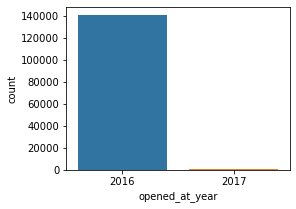

In [42]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x=incident_df1['opened_at_year'], ax=ax)
plt.show()

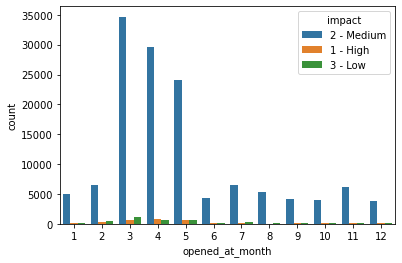

In [43]:
fig, ax = plt.subplots()
sns.countplot(x=incident_df1['opened_at_month'], ax=ax, hue=incident_df1['impact'])
plt.show()

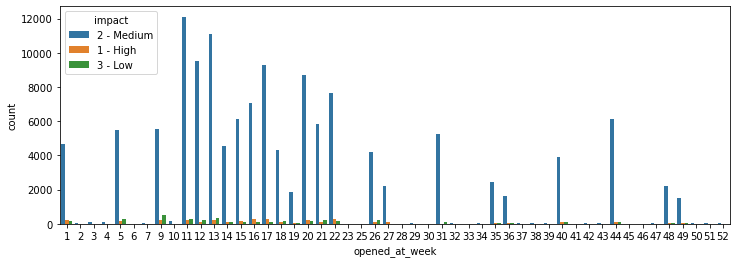

In [44]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['opened_at_week'], ax=ax, hue=incident_df1['impact'])
plt.show()

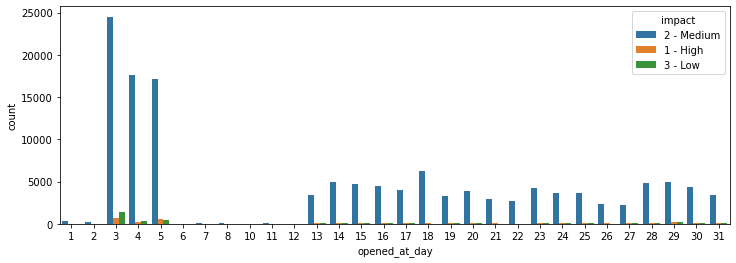

In [45]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['opened_at_day'], ax=ax, hue=incident_df1['impact'])
plt.show()

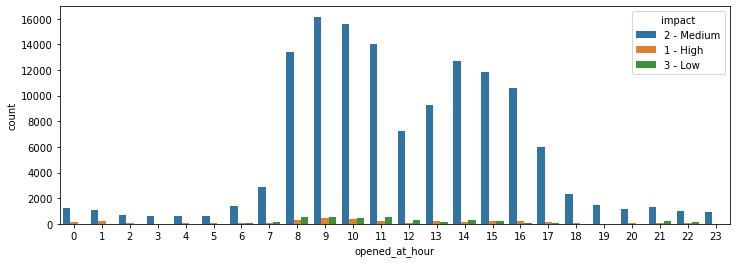

In [46]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['opened_at_hour'], ax=ax, hue=incident_df1['impact'])
plt.show()

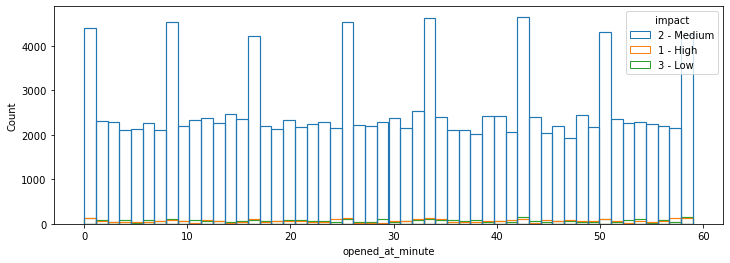

In [47]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x=incident_df1['opened_at_minute'], ax=ax,hue=incident_df1['impact'], fill=False)
plt.show()

#### 3.3.3 Features from  'sys_updated_at'
'sys_updated_at_year', 'sys_updated_at_month', 'sys_updated_at_week', 'sys_updated_at_day', 'sys_updated_at_hour', 'sys_updated_at_minute'

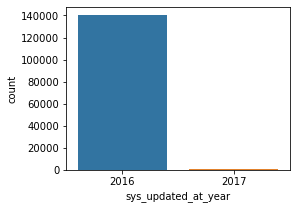

In [48]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x=incident_df1['sys_updated_at_year'], ax=ax)
plt.show()

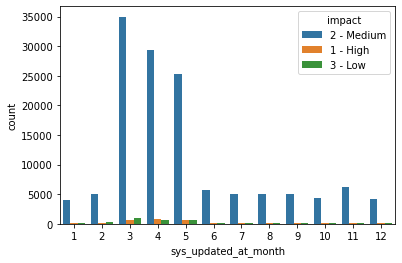

In [49]:
fig, ax = plt.subplots()
sns.countplot(x=incident_df1['sys_updated_at_month'], ax=ax, hue=incident_df1['impact'])
plt.show()

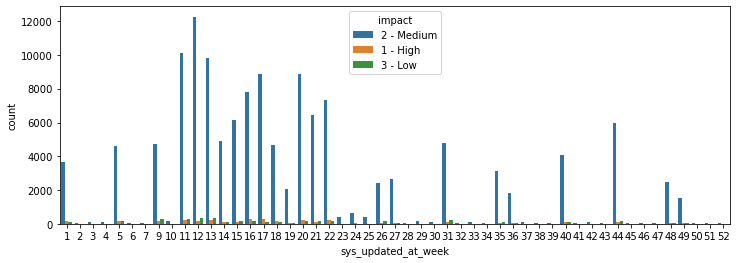

In [50]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['sys_updated_at_week'], ax=ax, hue=incident_df1['impact'])
plt.show()

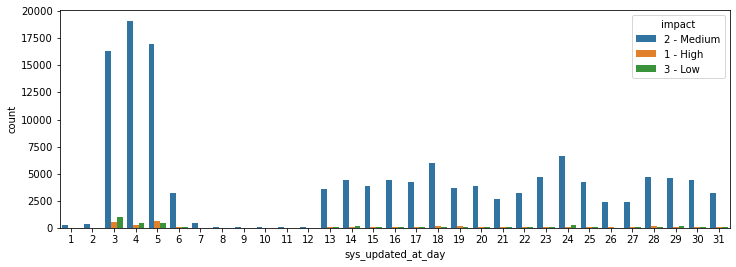

In [51]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['sys_updated_at_day'], ax=ax, hue=incident_df1['impact'])
plt.show()

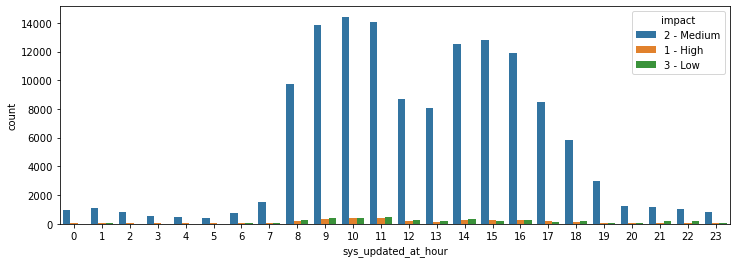

In [52]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['sys_updated_at_hour'], ax=ax, hue=incident_df1['impact'])
plt.show()

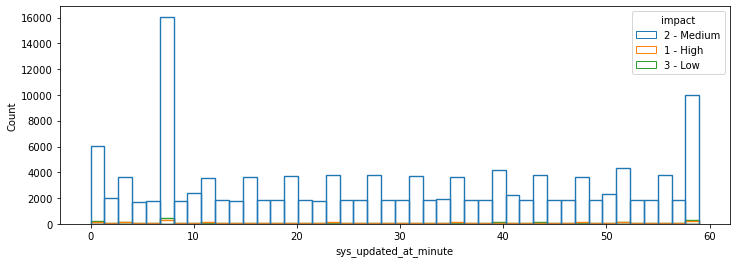

In [53]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x=incident_df1['sys_updated_at_minute'], ax=ax,hue=incident_df1['impact'], fill=False)
plt.show()

#### 3.3.4 Features from  'resolved_at'
'resolved_at_year', 'resolved_at_month', 'resolved_at_week', 'resolved_at_day', 'resolved_at_hour', 'resolved_at_minute'

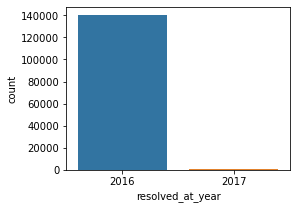

In [54]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x=incident_df1['resolved_at_year'], ax=ax)
plt.show()

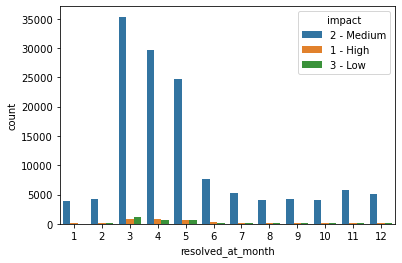

In [55]:
fig, ax = plt.subplots()
sns.countplot(x=incident_df1['resolved_at_month'], ax=ax, hue=incident_df1['impact'])
plt.show()

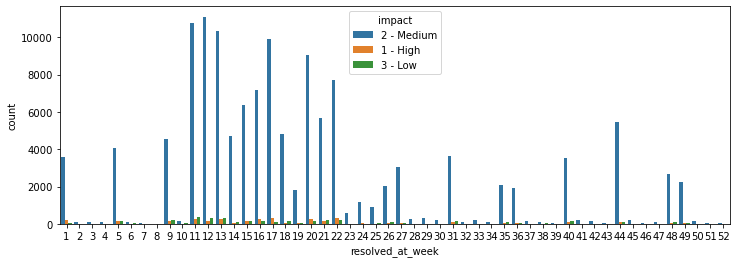

In [56]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['resolved_at_week'], ax=ax, hue=incident_df1['impact'])
plt.show()

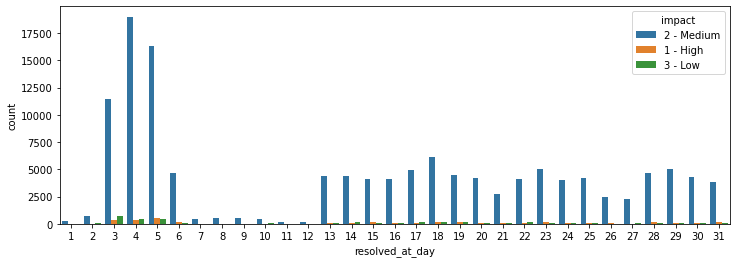

In [57]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['resolved_at_day'], ax=ax, hue=incident_df1['impact'])
plt.show()

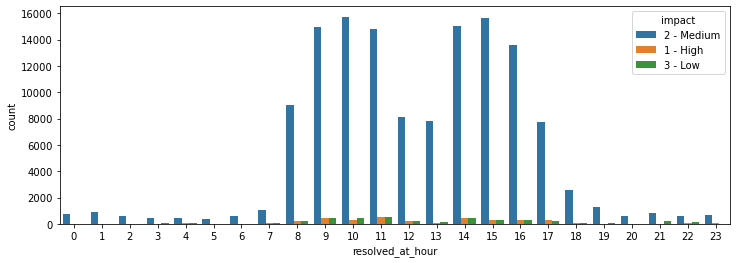

In [58]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['resolved_at_hour'], ax=ax, hue=incident_df1['impact'])
plt.show()

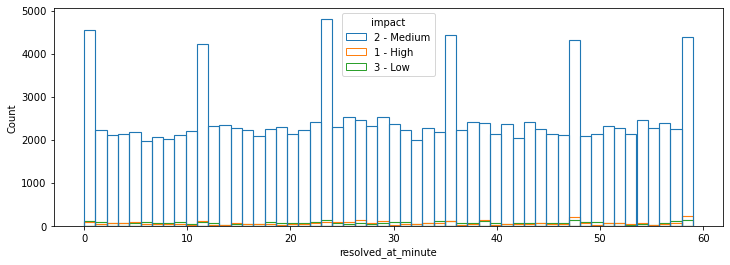

In [59]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x=incident_df1['resolved_at_minute'], ax=ax, hue=incident_df1['impact'], fill=False)
plt.show()

#### 3.3.5 Features from  'closed_at'
'closed_at_year', 'closed_at_month', 'closed_at_week', 'closed_at_day', 'closed_at_hour', 'closed_at_minute'

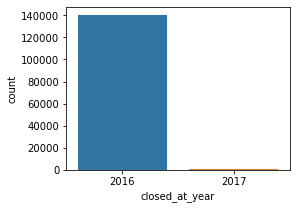

In [60]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x=incident_df1['closed_at_year'], ax=ax)
plt.show()

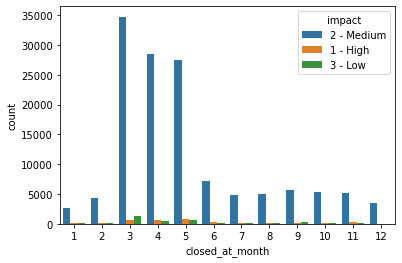

In [61]:
fig, ax = plt.subplots()
sns.countplot(x=incident_df1['closed_at_month'], ax=ax, hue=incident_df1['impact'])
plt.show()

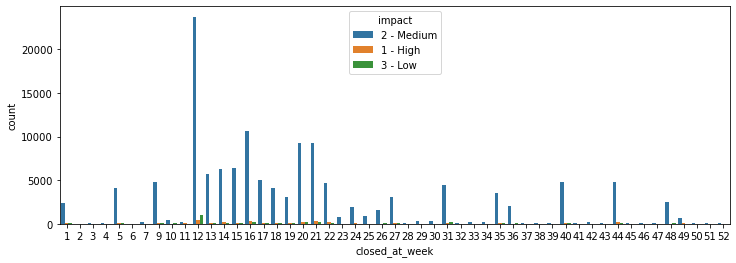

In [62]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['closed_at_week'], ax=ax, hue=incident_df1['impact'])
plt.show()

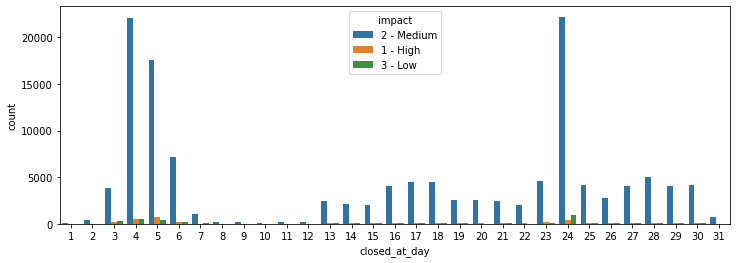

In [63]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['closed_at_day'], ax=ax, hue=incident_df1['impact'])
plt.show()

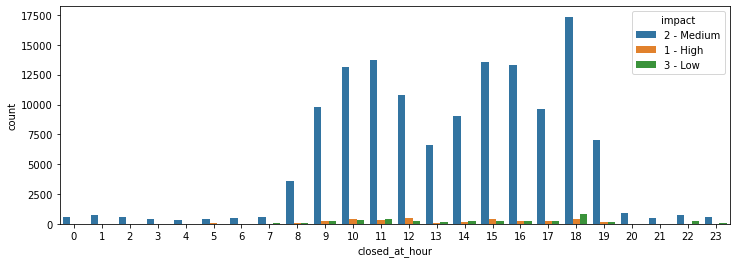

In [64]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=incident_df1['closed_at_hour'], ax=ax, hue=incident_df1['impact'])
plt.show()

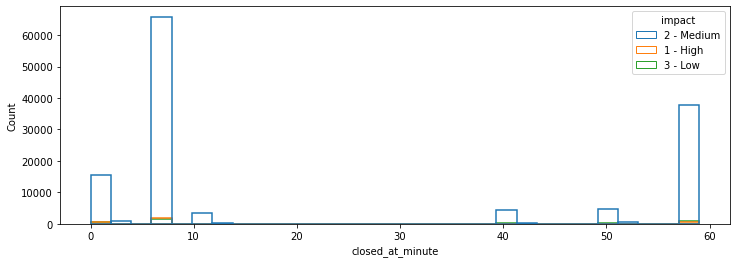

In [65]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x=incident_df1['closed_at_minute'], ax=ax,hue=incident_df1['impact'], fill=False)
plt.show()

### 3.4 Encoding target labels

In [66]:
# Encoding the labels of the target column.
def out_label_encoder(ydf):
    impact_scale = {'1 - High':1, '2 - Medium':2, '3 - Low':3}
    ydf = ydf.map(impact_scale)
    return ydf    

In [67]:
incident_df1['impact'] = out_label_encoder(incident_df1['impact'])

In [68]:
incident_df1.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,impact,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute
0,45,1,0,0,0,1,8,2,2,3,17,1,0,0,3.0,12.0,6.0,46.0,47.0,1462.0,104.0,43.0,69.0,501.0,51.0,2016,2,9,29,1,16,2016,2,9,29,11,29,2016,2,9,29,1,23,2016,5,18,3,12,0
1,45,1,0,0,2,1,8,2,2,3,17,1,0,0,3.0,12.0,7.0,46.0,47.0,1462.0,509.0,43.0,69.0,501.0,51.0,2016,2,9,29,1,16,2016,2,9,29,11,29,2016,2,9,29,8,53,2016,5,18,3,12,0
2,45,1,0,0,3,1,8,2,2,3,17,1,0,0,3.0,12.0,7.0,46.0,47.0,1462.0,658.0,43.0,69.0,501.0,51.0,2016,2,9,29,1,16,2016,2,9,29,11,29,2016,2,9,29,11,29,2016,5,18,3,12,0
3,45,0,0,0,4,1,8,2,2,3,17,1,0,0,3.0,12.0,5.0,46.0,47.0,1462.0,762.0,43.0,69.0,501.0,51.0,2016,2,9,29,1,16,2016,2,9,29,11,29,2016,5,18,3,12,0,2016,5,18,3,12,0
4,47,1,0,0,0,1,397,2,2,3,89,1,0,0,3.0,12.0,6.0,30.0,63.0,1462.0,605.0,62.0,112.0,352.0,196.0,2016,2,9,29,4,40,2016,1,1,3,9,52,2016,2,9,29,4,57,2016,6,22,3,10,0


### 3.5 Correlation plots

#### 3.5.1 Correlation between all features and target

In [69]:
incident_corr1 = incident_df1.corr()

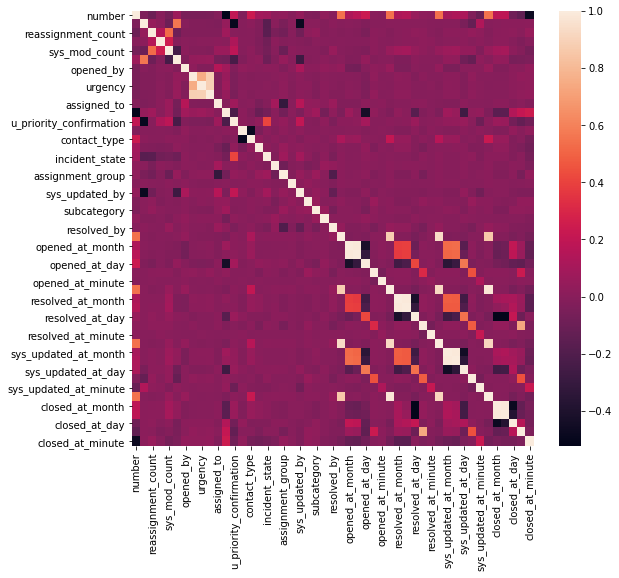

In [70]:
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(incident_corr1, ax=ax, annot=False)
#fig.savefig('heatmap_incident.jpg', bbox_inches='tight', dpi=150) # TO save the plot to jpg
plt.show()

#### 3.5.2 Correlation between 'urgency', 'priority' and 'impact'

In [71]:
incident_corr2 = incident_df1[['urgency', 'priority', 'impact']].corr()

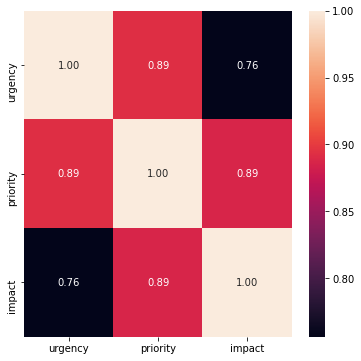

In [72]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(incident_corr2, ax=ax, annot=True, fmt='.2f')
#fig.savefig('heatmap_incident_lowcrd.jpg', bbox_inches='tight', dpi=150)
plt.show()

### 3.6 Expectation from the classifier for class predictions.

In [73]:
target_class_prob = incident_df1['impact'].value_counts().to_dict()

In [74]:
target_class_sumry = pd.concat([pd.Series(target_class_prob.keys()),
                                pd.Series(target_class_prob.values())],
                       axis=1)
target_class_sumry.columns = ['class', 'observations']

In [75]:
tot_num_obs = target_class_sumry['observations'].sum()

In [76]:
target_class_sumry['p_class'] = target_class_sumry['observations'].apply(lambda x: round(x/tot_num_obs, 3))

In [77]:
target_class_sumry # Expectation

,class,observations,p_class
0,2,134335,0.948
1,3,3886,0.027
2,1,3491,0.025


## 4. Data preparation

### 4.1 Splitting data into features and target.

In [78]:
target = 'impact'
features = [col for col in incident_df.columns if col != 'impact']

In [79]:
# data split 
X = incident_df.loc[:, features] 
y = incident_df.loc[:, target]

In [80]:
X.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [81]:
y.head()

0    2 - Medium
1    2 - Medium
2    2 - Medium
3    2 - Medium
4    2 - Medium
Name: impact, dtype: object

### 4.2 Data preprocessing 

In [82]:
# Final  data preprocessing function that includes the above preprocessing steps for all features.
def data_preprocessor(Xdf):
    Xdf =  null_value_remove(Xdf)
    Xdf =  null_value_impute(Xdf)
    Xdf =  boolean_encoder(Xdf)
    
    datetime_cols = ['opened_at', 'sys_updated_at', 'resolved_at', 'closed_at']
    Xdf =  date_time_converter(Xdf, datetime_cols)
    extracted_features = pd.concat(feature_extract_dt(Xdf), axis=1)
    Xdf = Xdf.drop(datetime_cols, axis=1)
    Xdf = pd.concat([Xdf, extracted_features], axis=1)
    
    Xdf = categorical_encoder(Xdf) 
    
    return Xdf

In [83]:
%%time
# Preprocessing the features.
X_prep = data_preprocessor(X)

Wall time: 17.9 s


In [84]:
%%time
# Preprocessing the target.
y_prep = out_label_encoder(y)

Wall time: 13 ms


### 4.3 Train test split

In [85]:
# Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.2, stratify=y_prep, random_state=42)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113369, 48), (28343, 48), (113369,), (28343,))

In [87]:
X_train.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
132661,32475,1,0,0,1,1,55,2,3,28,0,1,0,2016,5,21,24,9,14,2016,5,21,24,9,37,2016,5,21,24,9,37,2016,5,21,29,10,7,3.0,13.0,7.0,32.0,63.0,880.0,24.0,160.0,120.0,411.0,142.0
123147,30070,0,1,0,10,0,8,2,3,140,0,1,0,2016,5,20,16,20,23,2016,5,21,23,11,34,2016,5,21,28,12,7,2016,5,21,28,12,7,3.0,13.0,5.0,12.0,16.0,4584.0,762.0,104.0,73.0,365.0,28.0
81805,19472,1,0,0,0,1,24,2,3,17,0,0,0,2016,4,15,15,8,46,2016,4,15,15,8,49,2016,4,15,15,8,46,2016,4,16,20,9,7,3.0,13.0,0.0,15.0,63.0,3810.0,762.0,221.0,74.0,365.0,52.0
24440,5443,1,1,0,2,1,301,2,3,17,1,0,0,2016,10,40,3,13,35,2016,11,44,3,10,22,2016,10,40,3,18,13,2016,3,12,24,18,51,3.0,14.0,0.0,9.0,63.0,2906.0,27.0,217.0,26.0,394.0,52.0
18891,4120,1,3,0,7,1,59,2,3,57,1,0,0,2016,8,31,3,10,30,2016,3,11,14,10,35,2016,3,11,14,10,35,2016,3,12,24,18,50,3.0,13.0,0.0,27.0,16.0,1383.0,107.0,77.0,36.0,272.0,169.0


In [88]:
X_test.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
121872,29727,1,0,0,1,1,24,2,3,17,0,1,0,2016,5,20,16,9,54,2016,5,20,16,9,56,2016,5,20,16,9,56,2016,5,20,21,10,7,3.0,13.0,7.0,32.0,63.0,2460.0,468.0,217.0,120.0,365.0,52.0
5313,1287,1,0,0,2,1,468,2,3,133,1,0,0,2016,2,5,3,12,58,2016,11,45,8,11,43,2016,2,5,3,13,0,2016,8,33,16,12,0,3.0,13.0,0.0,35.0,13.0,1432.0,651.0,104.0,126.0,94.0,21.0
65584,15348,1,0,0,0,1,17,2,3,17,0,0,0,2016,5,18,4,9,53,2016,5,18,4,10,22,2016,5,18,4,9,53,2016,10,40,4,10,59,3.0,13.0,6.0,32.0,63.0,5020.0,762.0,7.0,120.0,365.0,11.0
137091,33660,0,0,0,4,1,131,3,4,236,0,1,0,2016,5,22,30,9,54,2016,5,22,30,12,26,2016,4,14,6,13,7,2016,4,14,6,13,7,3.0,16.0,5.0,44.0,19.0,215.0,762.0,43.0,73.0,365.0,122.0
96338,23275,1,0,0,0,1,24,2,3,182,0,0,0,2016,4,17,27,14,56,2016,4,17,28,16,27,2016,4,17,27,15,0,2016,3,9,5,17,7,3.0,15.0,6.0,36.0,23.0,3995.0,468.0,210.0,244.0,365.0,69.0


In [89]:
test_df = pd.concat([X_test, y_test], axis=1)

In [90]:
test_df.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by,impact
121872,29727,1,0,0,1,1,24,2,3,17,0,1,0,2016,5,20,16,9,54,2016,5,20,16,9,56,2016,5,20,16,9,56,2016,5,20,21,10,7,3.0,13.0,7.0,32.0,63.0,2460.0,468.0,217.0,120.0,365.0,52.0,2
5313,1287,1,0,0,2,1,468,2,3,133,1,0,0,2016,2,5,3,12,58,2016,11,45,8,11,43,2016,2,5,3,13,0,2016,8,33,16,12,0,3.0,13.0,0.0,35.0,13.0,1432.0,651.0,104.0,126.0,94.0,21.0,2
65584,15348,1,0,0,0,1,17,2,3,17,0,0,0,2016,5,18,4,9,53,2016,5,18,4,10,22,2016,5,18,4,9,53,2016,10,40,4,10,59,3.0,13.0,6.0,32.0,63.0,5020.0,762.0,7.0,120.0,365.0,11.0,2
137091,33660,0,0,0,4,1,131,3,4,236,0,1,0,2016,5,22,30,9,54,2016,5,22,30,12,26,2016,4,14,6,13,7,2016,4,14,6,13,7,3.0,16.0,5.0,44.0,19.0,215.0,762.0,43.0,73.0,365.0,122.0,3
96338,23275,1,0,0,0,1,24,2,3,182,0,0,0,2016,4,17,27,14,56,2016,4,17,28,16,27,2016,4,17,27,15,0,2016,3,9,5,17,7,3.0,15.0,6.0,36.0,23.0,3995.0,468.0,210.0,244.0,365.0,69.0,2


In [91]:
test_df.to_csv("incident_impact_test.csv")

In [92]:
y_train[:5]

132661    2
123147    2
81805     2
24440     2
18891     2
Name: impact, dtype: int64

In [93]:
y_test[y_test==1]

95092     1
124909    1
92778     1
123526    1
458       1
         ..
31546     1
61995     1
65311     1
2999      1
129122    1
Name: impact, Length: 698, dtype: int64

### 4.4 Feature scaling

In [94]:
# Normalizing the data. 
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_prep.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_prep.columns, index=X_test.index)
X_test.columns = X_prep.columns

In [95]:
X_train.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
132661,0.267974,1.0,0.000000,0.0,0.007752,1.0,0.098881,0.5,0.666667,0.103586,0.0,1.0,0.0,0.0,0.363636,0.392157,0.766667,0.391304,0.237288,0.0,0.363636,0.392157,0.766667,0.391304,0.627119,0.0,0.363636,0.392157,0.766667,0.391304,0.627119,0.0,0.363636,0.392157,0.933333,0.434783,0.118644,0.75,0.8125,1.000000,0.561404,0.818182,0.167843,0.028402,0.717489,0.474308,0.784351,0.660465
123147,0.248102,0.0,0.037037,0.0,0.077519,0.0,0.011194,0.5,0.666667,0.549801,0.0,1.0,0.0,0.0,0.363636,0.372549,0.500000,0.869565,0.389831,0.0,0.363636,0.392157,0.733333,0.478261,0.576271,0.0,0.363636,0.392157,0.900000,0.521739,0.118644,0.0,0.363636,0.392157,0.900000,0.521739,0.118644,0.75,0.8125,0.714286,0.210526,0.207792,0.874309,0.901775,0.466368,0.288538,0.696565,0.130233
81805,0.160529,1.0,0.000000,0.0,0.000000,1.0,0.041045,0.5,0.666667,0.059761,0.0,0.0,0.0,0.0,0.272727,0.274510,0.466667,0.347826,0.779661,0.0,0.272727,0.274510,0.466667,0.347826,0.830508,0.0,0.272727,0.274510,0.466667,0.347826,0.779661,0.0,0.272727,0.294118,0.633333,0.391304,0.118644,0.75,0.8125,0.000000,0.263158,0.818182,0.726683,0.901775,0.991031,0.292490,0.696565,0.241860
24440,0.044605,1.0,0.037037,0.0,0.015504,1.0,0.557836,0.5,0.666667,0.059761,1.0,0.0,0.0,0.0,0.818182,0.764706,0.066667,0.565217,0.593220,0.0,0.909091,0.843137,0.066667,0.434783,0.372881,0.0,0.818182,0.764706,0.066667,0.782609,0.220339,0.0,0.181818,0.215686,0.766667,0.782609,0.864407,0.75,0.8750,0.000000,0.157895,0.818182,0.554263,0.031953,0.973094,0.102767,0.751908,0.241860
18891,0.033672,1.0,0.111111,0.0,0.054264,1.0,0.106343,0.5,0.666667,0.219124,1.0,0.0,0.0,0.0,0.636364,0.588235,0.066667,0.434783,0.508475,0.0,0.181818,0.196078,0.433333,0.434783,0.593220,0.0,0.181818,0.196078,0.433333,0.434783,0.593220,0.0,0.181818,0.215686,0.766667,0.782609,0.847458,0.75,0.8125,0.000000,0.473684,0.207792,0.263780,0.126627,0.345291,0.142292,0.519084,0.786047


In [96]:
X_test.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
121872,0.245267,1.0,0.0,0.0,0.007752,1.0,0.041045,0.5,0.666667,0.059761,0.0,1.0,0.0,0.0,0.363636,0.372549,0.500000,0.391304,0.915254,0.0,0.363636,0.372549,0.500000,0.391304,0.949153,0.0,0.363636,0.372549,0.500000,0.391304,0.949153,0.0,0.363636,0.372549,0.666667,0.434783,0.118644,0.75,0.8125,1.000000,0.561404,0.818182,0.469197,0.553846,0.973094,0.474308,0.696565,0.241860
5313,0.010263,1.0,0.0,0.0,0.015504,1.0,0.869403,0.5,0.666667,0.521912,1.0,0.0,0.0,0.0,0.090909,0.078431,0.066667,0.521739,0.983051,0.0,0.909091,0.862745,0.233333,0.478261,0.728814,0.0,0.090909,0.078431,0.066667,0.565217,0.000000,0.0,0.636364,0.627451,0.500000,0.521739,0.000000,0.75,0.8125,0.000000,0.614035,0.168831,0.273126,0.770414,0.466368,0.498024,0.179389,0.097674
65584,0.126451,1.0,0.0,0.0,0.000000,1.0,0.027985,0.5,0.666667,0.059761,0.0,0.0,0.0,0.0,0.363636,0.333333,0.100000,0.391304,0.898305,0.0,0.363636,0.333333,0.100000,0.434783,0.372881,0.0,0.363636,0.333333,0.100000,0.391304,0.898305,0.0,0.818182,0.764706,0.100000,0.434783,1.000000,0.75,0.8125,0.857143,0.561404,0.818182,0.957467,0.901775,0.031390,0.474308,0.696565,0.051163
137091,0.277766,0.0,0.0,0.0,0.031008,1.0,0.240672,1.0,1.000000,0.932271,0.0,1.0,0.0,0.0,0.363636,0.411765,0.966667,0.391304,0.915254,0.0,0.363636,0.411765,0.966667,0.521739,0.440678,0.0,0.272727,0.254902,0.166667,0.565217,0.118644,0.0,0.272727,0.254902,0.166667,0.565217,0.118644,0.75,1.0000,0.714286,0.771930,0.246753,0.041007,0.901775,0.192825,0.288538,0.696565,0.567442
96338,0.191953,1.0,0.0,0.0,0.000000,1.0,0.041045,0.5,0.666667,0.717131,0.0,0.0,0.0,0.0,0.272727,0.313725,0.866667,0.608696,0.949153,0.0,0.272727,0.313725,0.900000,0.695652,0.457627,0.0,0.272727,0.313725,0.866667,0.652174,0.000000,0.0,0.181818,0.156863,0.133333,0.739130,0.118644,0.75,0.9375,0.857143,0.631579,0.298701,0.761968,0.553846,0.941704,0.964427,0.696565,0.320930


### 5. Model Building

### 5.1 Baseline model
Note: The preprocessed data is used and all features are considered for the baseline model.

In [97]:
# Function to initialize, train and give predictions 
def clf_model(Xtrain, Xtest,  ytrain, ytest, classifier):
    """Fits the model specified in 'classifier' and returns
    predictions for both train and test data sets along with
    the fitted model.
    Inputs:
    ------
    Xtrain, Xtest,  ytrain, ytest, classifier
    
    outputs:
    ------
    ypred_train, ypred_test, clf
    """
    clf = classifier
    clf.fit(Xtrain, ytrain)
    
    ypred_train = clf.predict(Xtrain)
    ypred_test = clf.predict(Xtest)
    
    # Train data performance
    #display_results(ytrain, ypred_train, clf)
    #display_results(ytest, ypred_test, clf)  
    return ypred_train, ypred_test, clf

In [98]:
# Function to evaluate model
def display_results(y_test, y_pred, clf):
    """Displays model evaluation/performance report that includes
    accuracy_score, confusion_matrix, precision_score, and 
    recall_score.
    input
    -----
    y_test, y_pred
    
    output
    ------
    Model evaluation/performance report"""
    print(classification_report(y_test, y_pred))
    #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=clf.classes_, ax=ax)

In [99]:
# M1 decision tree all features considered.
y_pred_train, y_pred_test, clf =clf_model(Xtrain=X_train,
          Xtest=X_test,
          ytrain=y_train,
          ytest=y_test,
          classifier=DecisionTreeClassifier(random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2793
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00      3109

    accuracy                           1.00    113369
   macro avg       1.00      1.00      1.00    113369
weighted avg       1.00      1.00      1.00    113369



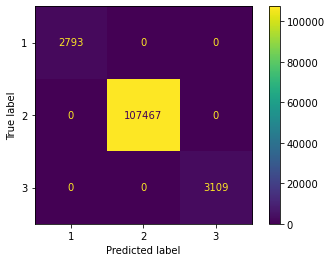

In [100]:
display_results(y_train, y_pred_train, clf)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



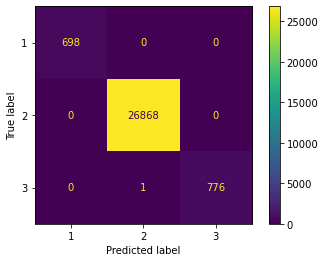

In [101]:
display_results(y_test, y_pred_test, clf)

In [102]:
def weighted_avg_scores(y_test, y_pred_test):
    scores = []
    prec_bs = round(precision_score(y_test, y_pred_test, average='weighted'),3)
    rec_bs = round(recall_score(y_test, y_pred_test, average='weighted'),3)
    f1_bs = round(f1_score(y_test, y_pred_test, average='weighted'),3)
    acc_bs = round(accuracy_score(y_test, y_pred_test))
    scores = [prec_bs, rec_bs, f1_bs, acc_bs]
    return scores

In [103]:
scores_bs = weighted_avg_scores(y_test, y_pred_test)

In [104]:
scores_bs

[1.0, 1.0, 1.0, 1]

In [105]:
#metrics = ['precision', 'recall', 'f1_score', 'accuracy']

### 5.2 Feature selection

#### 5.2.1 Chi2 Method

In [106]:
# Feature Extraction with Univariate Statistical Chi-squared Test for classification)
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X_train, y_train)
# summarize scores
#set_printoptions(precision=3)
#print(fit.scores_)
sel_features = fit.transform(X_train)

In [107]:
# Summarixing the scores
scores = fit.scores_
scores = pd.Series(scores)
scores.index = X_prep.columns
scores = scores.sort_values(ascending=False)

In [108]:
scores[:10]

urgency                    1786.577631
priority                   1784.770478
knowledge                   864.118637
opened_by                   208.896875
u_priority_confirmation     102.959102
closed_at_minute             45.474450
resolved_by                  42.162729
opened_at_day                34.478321
number                       28.300496
sys_updated_at_day           22.844291
dtype: float64

<AxesSubplot:>

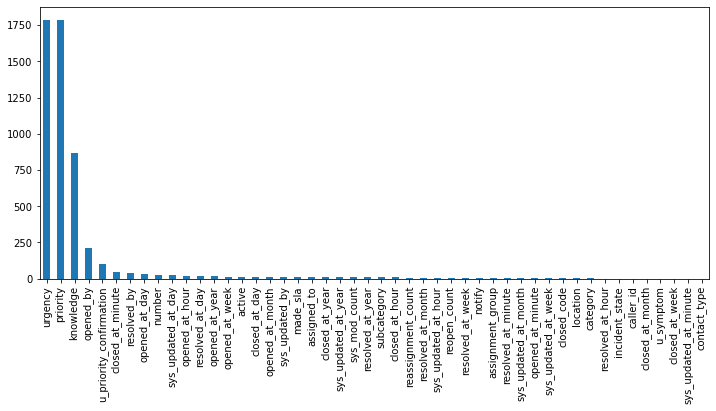

In [109]:
plt.figure(figsize=(12,5))
scores.plot.bar()

#### 5.2.2 Mutual information classification

In [110]:
from sklearn.feature_selection import mutual_info_classif
fs = SelectKBest(score_func=mutual_info_classif, k=10)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
#print(fs.scores_)

In [111]:
X_prep.columns[fs.get_support()]

Index(['number', 'opened_by', 'urgency', 'priority', 'assigned_to',
       'caller_id', 'sys_updated_by', 'subcategory', 'u_symptom',
       'resolved_by'],
      dtype='object')

#### 5.2.3 Feature importance using decision tree

In [112]:
from sklearn.tree import  DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
fit=model.fit(X_train, y_train)
print(model.feature_importances_)

[5.60548007e-03 0.00000000e+00 9.28989907e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.95389964e-03 1.04748525e-01
 8.73743025e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.26229195e-04 1.25769877e-03 3.91834004e-04
 8.45962256e-04 0.00000000e+00 1.65953225e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.44698592e-03 1.72798796e-04 2.33631635e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.13536292e-03 0.00000000e+00 1.18106001e-03 0.00000000e+00
 0.00000000e+00 2.90064264e-03 4.57139671e-04 1.04781306e-04]


In [113]:
features_imp=model.feature_importances_
features_imp=pd.Series(features_imp)
features_imp.index=X_prep.columns
features_imp=features_imp.sort_values(ascending=False)

<AxesSubplot:>

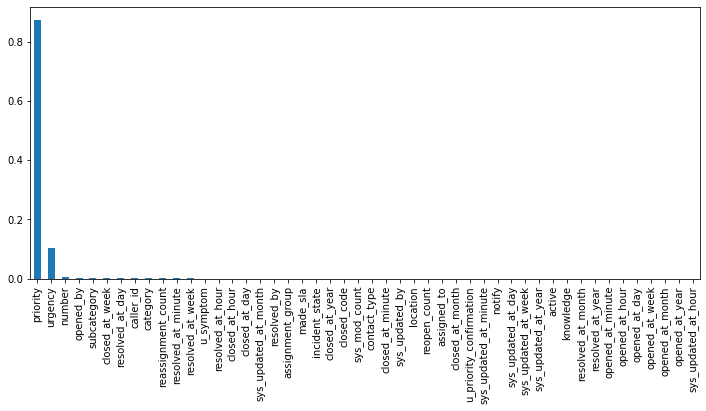

In [114]:
plt.figure(figsize=(12,5))
features_imp.plot.bar()

In [115]:
print(features_imp[:10])

priority              0.873743
urgency               0.104749
number                0.005605
opened_by             0.002954
subcategory           0.002901
closed_at_week        0.002447
resolved_at_day       0.001258
caller_id             0.001181
category              0.001135
reassignment_count    0.000929
dtype: float64


#### 5.2.4 Final set of features

In [116]:
#Top 15 selected features from each model
chi2_features=scores[:10].to_dict()
chi2_features=set(chi2_features.keys())

mutualinfo_features=set(X_prep.columns[fs.get_support()])

rfe_features=features_imp[:13].to_dict()
rfe_features=set(rfe_features.keys())

In [117]:
features_imp[:10].keys()

Index(['priority', 'urgency', 'number', 'opened_by', 'subcategory',
       'closed_at_week', 'resolved_at_day', 'caller_id', 'category',
       'reassignment_count'],
      dtype='object')

In [118]:
#Use intersection fuction to get the common features from all the three sets
chi2_features = chi2_features.intersection(mutualinfo_features)
output_set = chi2_features.intersection(rfe_features)
output_list = list(output_set)
print("Final list of features: ",output_list)

Final list of features:  ['priority', 'urgency', 'number', 'opened_by']


### 5.3 Training and validation with different models

In [119]:
X_train.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
132661,0.267974,1.0,0.000000,0.0,0.007752,1.0,0.098881,0.5,0.666667,0.103586,0.0,1.0,0.0,0.0,0.363636,0.392157,0.766667,0.391304,0.237288,0.0,0.363636,0.392157,0.766667,0.391304,0.627119,0.0,0.363636,0.392157,0.766667,0.391304,0.627119,0.0,0.363636,0.392157,0.933333,0.434783,0.118644,0.75,0.8125,1.000000,0.561404,0.818182,0.167843,0.028402,0.717489,0.474308,0.784351,0.660465
123147,0.248102,0.0,0.037037,0.0,0.077519,0.0,0.011194,0.5,0.666667,0.549801,0.0,1.0,0.0,0.0,0.363636,0.372549,0.500000,0.869565,0.389831,0.0,0.363636,0.392157,0.733333,0.478261,0.576271,0.0,0.363636,0.392157,0.900000,0.521739,0.118644,0.0,0.363636,0.392157,0.900000,0.521739,0.118644,0.75,0.8125,0.714286,0.210526,0.207792,0.874309,0.901775,0.466368,0.288538,0.696565,0.130233
81805,0.160529,1.0,0.000000,0.0,0.000000,1.0,0.041045,0.5,0.666667,0.059761,0.0,0.0,0.0,0.0,0.272727,0.274510,0.466667,0.347826,0.779661,0.0,0.272727,0.274510,0.466667,0.347826,0.830508,0.0,0.272727,0.274510,0.466667,0.347826,0.779661,0.0,0.272727,0.294118,0.633333,0.391304,0.118644,0.75,0.8125,0.000000,0.263158,0.818182,0.726683,0.901775,0.991031,0.292490,0.696565,0.241860
24440,0.044605,1.0,0.037037,0.0,0.015504,1.0,0.557836,0.5,0.666667,0.059761,1.0,0.0,0.0,0.0,0.818182,0.764706,0.066667,0.565217,0.593220,0.0,0.909091,0.843137,0.066667,0.434783,0.372881,0.0,0.818182,0.764706,0.066667,0.782609,0.220339,0.0,0.181818,0.215686,0.766667,0.782609,0.864407,0.75,0.8750,0.000000,0.157895,0.818182,0.554263,0.031953,0.973094,0.102767,0.751908,0.241860
18891,0.033672,1.0,0.111111,0.0,0.054264,1.0,0.106343,0.5,0.666667,0.219124,1.0,0.0,0.0,0.0,0.636364,0.588235,0.066667,0.434783,0.508475,0.0,0.181818,0.196078,0.433333,0.434783,0.593220,0.0,0.181818,0.196078,0.433333,0.434783,0.593220,0.0,0.181818,0.215686,0.766667,0.782609,0.847458,0.75,0.8125,0.000000,0.473684,0.207792,0.263780,0.126627,0.345291,0.142292,0.519084,0.786047


In [120]:
y_train[:5]

132661    2
123147    2
81805     2
24440     2
18891     2
Name: impact, dtype: int64

In [121]:
sel_features = output_list # ['number', 'priority', 'urgency', 'opened_by']

In [122]:
X_train1 = X_train[sel_features].copy()
X_test1 = X_test[sel_features].copy()

In [123]:
X_test.head()

,number,active,reassignment_count,reopen_count,sys_mod_count,made_sla,opened_by,urgency,priority,assigned_to,knowledge,u_priority_confirmation,notify,opened_at_year,opened_at_month,opened_at_week,opened_at_day,opened_at_hour,opened_at_minute,resolved_at_year,resolved_at_month,resolved_at_week,resolved_at_day,resolved_at_hour,resolved_at_minute,sys_updated_at_year,sys_updated_at_month,sys_updated_at_week,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,closed_at_year,closed_at_month,closed_at_week,closed_at_day,closed_at_hour,closed_at_minute,contact_type,closed_code,incident_state,category,assignment_group,caller_id,sys_updated_by,location,subcategory,u_symptom,resolved_by
121872,0.245267,1.0,0.0,0.0,0.007752,1.0,0.041045,0.5,0.666667,0.059761,0.0,1.0,0.0,0.0,0.363636,0.372549,0.500000,0.391304,0.915254,0.0,0.363636,0.372549,0.500000,0.391304,0.949153,0.0,0.363636,0.372549,0.500000,0.391304,0.949153,0.0,0.363636,0.372549,0.666667,0.434783,0.118644,0.75,0.8125,1.000000,0.561404,0.818182,0.469197,0.553846,0.973094,0.474308,0.696565,0.241860
5313,0.010263,1.0,0.0,0.0,0.015504,1.0,0.869403,0.5,0.666667,0.521912,1.0,0.0,0.0,0.0,0.090909,0.078431,0.066667,0.521739,0.983051,0.0,0.909091,0.862745,0.233333,0.478261,0.728814,0.0,0.090909,0.078431,0.066667,0.565217,0.000000,0.0,0.636364,0.627451,0.500000,0.521739,0.000000,0.75,0.8125,0.000000,0.614035,0.168831,0.273126,0.770414,0.466368,0.498024,0.179389,0.097674
65584,0.126451,1.0,0.0,0.0,0.000000,1.0,0.027985,0.5,0.666667,0.059761,0.0,0.0,0.0,0.0,0.363636,0.333333,0.100000,0.391304,0.898305,0.0,0.363636,0.333333,0.100000,0.434783,0.372881,0.0,0.363636,0.333333,0.100000,0.391304,0.898305,0.0,0.818182,0.764706,0.100000,0.434783,1.000000,0.75,0.8125,0.857143,0.561404,0.818182,0.957467,0.901775,0.031390,0.474308,0.696565,0.051163
137091,0.277766,0.0,0.0,0.0,0.031008,1.0,0.240672,1.0,1.000000,0.932271,0.0,1.0,0.0,0.0,0.363636,0.411765,0.966667,0.391304,0.915254,0.0,0.363636,0.411765,0.966667,0.521739,0.440678,0.0,0.272727,0.254902,0.166667,0.565217,0.118644,0.0,0.272727,0.254902,0.166667,0.565217,0.118644,0.75,1.0000,0.714286,0.771930,0.246753,0.041007,0.901775,0.192825,0.288538,0.696565,0.567442
96338,0.191953,1.0,0.0,0.0,0.000000,1.0,0.041045,0.5,0.666667,0.717131,0.0,0.0,0.0,0.0,0.272727,0.313725,0.866667,0.608696,0.949153,0.0,0.272727,0.313725,0.900000,0.695652,0.457627,0.0,0.272727,0.313725,0.866667,0.652174,0.000000,0.0,0.181818,0.156863,0.133333,0.739130,0.118644,0.75,0.9375,0.857143,0.631579,0.298701,0.761968,0.553846,0.941704,0.964427,0.696565,0.320930


#### 5.3.1 Decision tree classifier

In [124]:
y_pred_train_dt, y_pred_test_dt, clf_dt =clf_model(Xtrain=X_train1,
          Xtest=X_test1,
          ytrain=y_train,
          ytest=y_test,
          classifier=DecisionTreeClassifier(random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2793
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00      3109

    accuracy                           1.00    113369
   macro avg       1.00      1.00      1.00    113369
weighted avg       1.00      1.00      1.00    113369



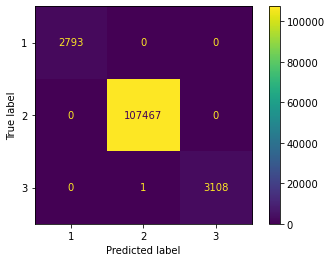

In [125]:
display_results(y_train, y_pred_train_dt, clf_dt)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



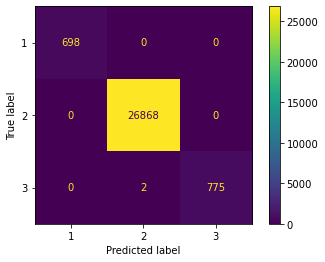

In [126]:
display_results(y_test, y_pred_test_dt, clf_dt)

#### 5.3.2 Random Forest classifier

In [127]:
y_pred_train_rf, y_pred_test_rf, clf_rf =clf_model(Xtrain=X_train1,
          Xtest=X_test1,
          ytrain=y_train,
          ytest=y_test,
          classifier=RandomForestClassifier(random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2793
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00      3109

    accuracy                           1.00    113369
   macro avg       1.00      1.00      1.00    113369
weighted avg       1.00      1.00      1.00    113369



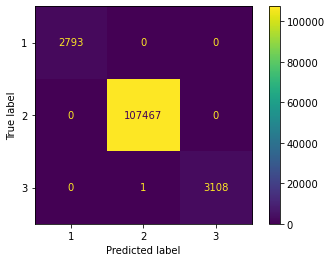

In [128]:
display_results(y_train, y_pred_train_rf, clf_rf)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



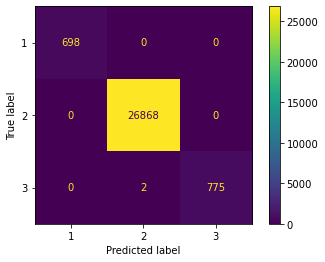

In [129]:
display_results(y_test, y_pred_test_rf, clf_rf)

#### 5.3.3 XGBoost classifier

In [130]:
y_pred_train_xb, y_pred_test_xb, clf_xb =clf_model(Xtrain=X_train1,
          Xtest=X_test1,
          ytrain=y_train,
          ytest=y_test,
          classifier=XGBClassifier(random_state=42))

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2793
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00      3109

    accuracy                           1.00    113369
   macro avg       1.00      1.00      1.00    113369
weighted avg       1.00      1.00      1.00    113369



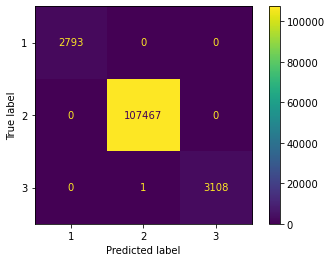

In [131]:
display_results(y_train, y_pred_train_xb, clf_xb)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



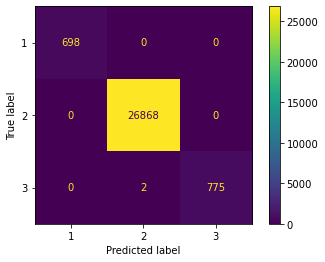

In [132]:
display_results(y_test, y_pred_test_xb, clf_xb)

#### 5.3 SMOTE for balancing the data (Sampling)

In [133]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
X_balanced,y_balanced=oversample.fit_resample(X_train,y_train)
y_balanced=pd.Series(y_balanced)

print("Impact counts before balancing:\n ",y_train.value_counts())
print("Impact counts after balancing: \n",y_balanced.value_counts())

Impact counts before balancing:
  2    107467
3      3109
1      2793
Name: impact, dtype: int64
Impact counts after balancing: 
 1    107467
2    107467
3    107467
Name: impact, dtype: int64


In [134]:
X_balanced.shape

(322401, 48)

### 5.4 Training and validation with different models after oversampling

#### 5.4.1 Decision tree 

In [135]:
X_train_os = X_balanced[sel_features].copy()
y_train_os = y_balanced.copy()

In [136]:
y_pred_train_os_dt, y_pred_test_os_dt, clf_os_dt =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=DecisionTreeClassifier(random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



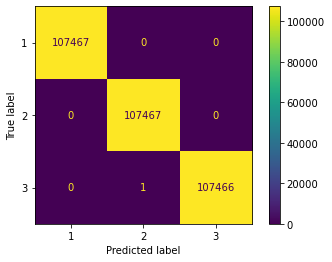

In [137]:
display_results(y_train_os, y_pred_train_os_dt, clf_os_dt)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



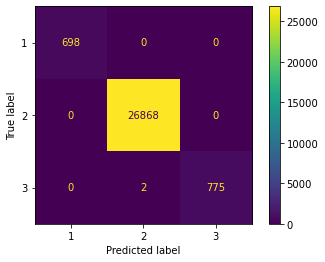

In [138]:
display_results(y_test, y_pred_test_os_dt, clf_os_dt)

#### 5.4.2 Random forest

In [139]:
y_pred_train_os_rf, y_pred_test_os_rf, clf_os_rf =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=RandomForestClassifier(random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



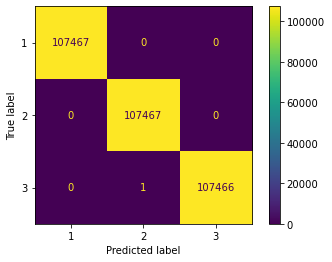

In [140]:
display_results(y_train_os, y_pred_train_os_rf, clf_os_rf)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



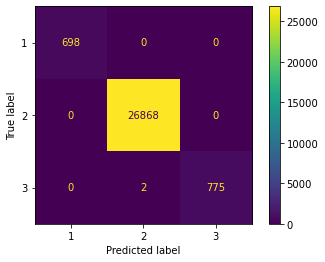

In [141]:
display_results(y_test, y_pred_test_os_rf, clf_os_rf)

#### 5.4.3 XGBoost

In [142]:
y_pred_train_os_xb, y_pred_test_os_xb, clf_os_xb =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=XGBClassifier(random_state=42))

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



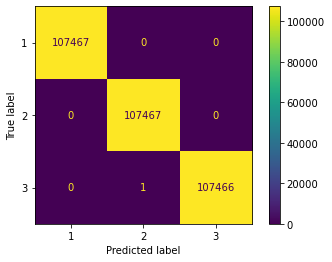

In [143]:
display_results(y_train_os, y_pred_train_os_xb, clf_os_xb)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



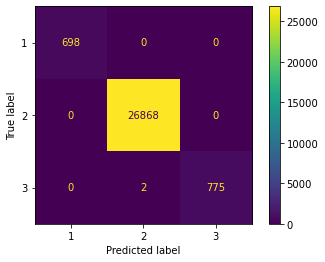

In [144]:
display_results(y_test, y_pred_test_os_xb, clf_os_xb)

#### 5.4.4 Adaboost

In [145]:
y_pred_train_os_ab, y_pred_test_os_ab, clf_os_ab =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                                random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       0.50      1.00      0.67    107467
           3       1.00      0.00      0.00    107467

    accuracy                           0.67    322401
   macro avg       0.83      0.67      0.56    322401
weighted avg       0.83      0.67      0.56    322401



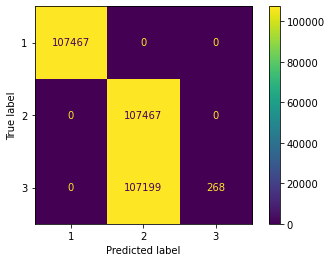

In [146]:
display_results(y_train_os, y_pred_train_os_ab, clf_os_ab)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       0.97      1.00      0.99     26868
           3       0.00      0.00      0.00       777

    accuracy                           0.97     28343
   macro avg       0.66      0.67      0.66     28343
weighted avg       0.95      0.97      0.96     28343



C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


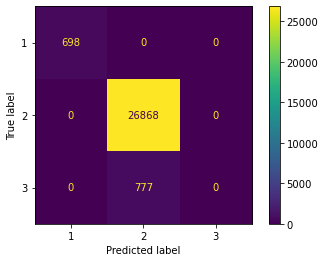

In [147]:
display_results(y_test, y_pred_test_os_ab, clf_os_ab)

#### 5.4.5 Catboost

In [148]:
#%pip install catboost

In [149]:
#from catboost import CatBoostClassifier

In [150]:
#y_pred_train_os_cb, y_pred_test_os_cb, clf_os_cb =clf_model(Xtrain=X_train_os,
         # Xtest=X_test1,
          #ytrain=y_train_os,
          #ytest=y_test,
          #classifier=CatBoostClassifier(random_state=42))

In [151]:
#display_results(y_train_os, y_pred_train_os_cb, clf_os_cb)

In [152]:
#display_results(y_test, y_pred_test_os_cb, clf_os_cb)

#### 5.4.6 LGBM

In [153]:
from lightgbm import LGBMClassifier

In [154]:
y_pred_train_os_lb, y_pred_test_os_lb, clf_os_lb =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=LGBMClassifier(random_state=42))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



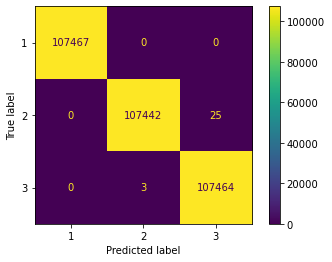

In [155]:
display_results(y_train_os, y_pred_train_os_lb, clf_os_lb)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       0.99      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



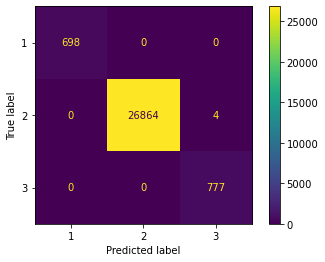

In [156]:
display_results(y_test, y_pred_test_os_lb, clf_os_lb)

#### 5.4.7 KNN

In [157]:
from sklearn.neighbors import KNeighborsClassifier    

In [158]:
y_pred_train_os_kn, y_pred_test_os_kn, clf_os_kn =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=KNeighborsClassifier(n_neighbors=1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



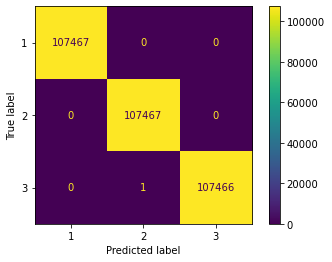

In [159]:
display_results(y_train_os, y_pred_train_os_kn, clf_os_kn)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       1.00      1.00      1.00       777

    accuracy                           1.00     28343
   macro avg       1.00      1.00      1.00     28343
weighted avg       1.00      1.00      1.00     28343



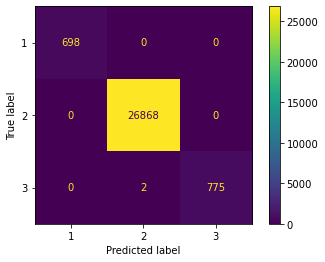

In [160]:
display_results(y_test, y_pred_test_os_kn, clf_os_kn)

#### 5.4.8 SVM

In [161]:
from sklearn.svm import SVC

In [162]:
y_pred_train_os_sv, y_pred_test_os_sv, clf_os_sv =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=SVC())

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



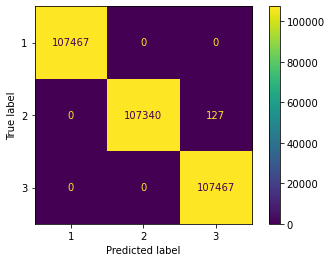

In [163]:
display_results(y_train_os, y_pred_train_os_sv, clf_os_sv)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       0.95      1.00      0.97       777

    accuracy                           1.00     28343
   macro avg       0.98      1.00      0.99     28343
weighted avg       1.00      1.00      1.00     28343



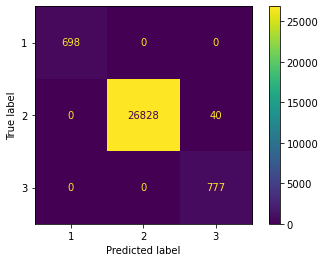

In [164]:
display_results(y_test, y_pred_test_os_sv, clf_os_sv)

#### 5.4.9 Gaussian Naive Bayes

In [165]:
from sklearn.naive_bayes import GaussianNB

In [166]:
y_pred_train_os_gnb, y_pred_test_os_gnb, clf_os_gnb =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=GaussianNB())

              precision    recall  f1-score   support

           1       0.98      1.00      0.99    107467
           2       1.00      0.99      0.99    107467
           3       1.00      0.99      1.00    107467

    accuracy                           0.99    322401
   macro avg       0.99      0.99      0.99    322401
weighted avg       0.99      0.99      0.99    322401



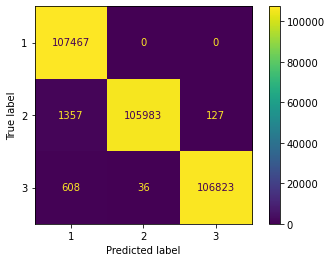

In [167]:
display_results(y_train_os, y_pred_train_os_gnb, clf_os_gnb)

              precision    recall  f1-score   support

           1       0.65      1.00      0.78       698
           2       1.00      0.98      0.99     26868
           3       0.95      1.00      0.97       777

    accuracy                           0.99     28343
   macro avg       0.87      0.99      0.92     28343
weighted avg       0.99      0.99      0.99     28343



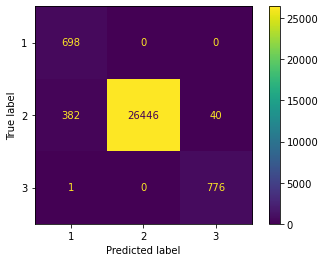

In [168]:
display_results(y_test, y_pred_test_os_gnb, clf_os_gnb)

#### 5.4.10 Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression

In [170]:
y_pred_train_os_log, y_pred_test_os_log, clf_os_log =clf_model(Xtrain=X_train_os,
          Xtest=X_test1,
          ytrain=y_train_os,
          ytest=y_test,
          classifier=LogisticRegression())

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    107467
           2       1.00      1.00      1.00    107467
           3       1.00      1.00      1.00    107467

    accuracy                           1.00    322401
   macro avg       1.00      1.00      1.00    322401
weighted avg       1.00      1.00      1.00    322401



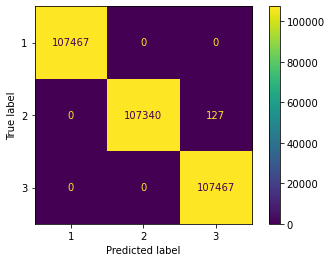

In [171]:
display_results(y_train_os, y_pred_train_os_log, clf_os_log)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       698
           2       1.00      1.00      1.00     26868
           3       0.95      1.00      0.97       777

    accuracy                           1.00     28343
   macro avg       0.98      1.00      0.99     28343
weighted avg       1.00      1.00      1.00     28343



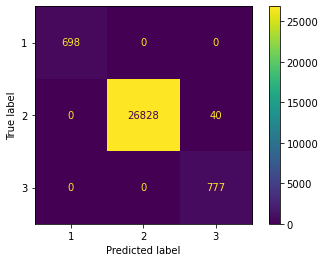

In [172]:
display_results(y_test, y_pred_test_os_log, clf_os_log)

### 6 Creating sample predictions for chosen model
#### Chosen model - Random forest

In [174]:
test_df = pd.read_csv('incident_impact_sample.csv') # opening a prepared dataset

In [175]:
sel_features

['priority', 'urgency', 'number', 'opened_by']

In [176]:
# sel_features = ['number', 'priority', 'urgency', 'opened_by']
test_df

,urgency,number,opened_by,priority,impact
0,2,29727,24,3,2
1,2,1287,468,3,2
2,2,15348,17,3,2
3,2,22969,305,2,1
4,2,30514,58,2,1
5,2,22377,24,2,1
6,3,33660,131,4,3
7,3,26073,20,4,3
8,3,2285,533,4,3


In [177]:
X_sample = test_df.iloc[:, :-1]
y_sample = test_df.iloc[:, -1]

In [178]:
sc = MinMaxScaler()
X_sample = pd.DataFrame(scaler.fit_transform(X_sample), columns=X_sample.columns, index=X_sample.index)

In [179]:
X_sample

,urgency,number,opened_by,priority
0,0.0,0.878510,0.013566,0.5
1,0.0,0.000000,0.874031,0.5
2,0.0,0.434343,0.000000,0.5
3,0.0,0.669756,0.558140,0.0
4,0.0,0.902820,0.079457,0.0
5,0.0,0.651469,0.013566,0.0
6,1.0,1.000000,0.220930,1.0
7,1.0,0.765638,0.005814,1.0
8,1.0,0.030828,1.000000,1.0


In [180]:
y_sample_pred = pd.DataFrame(clf_rf.predict(X_sample), columns=['impact_pred'])

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [181]:
y_sample_pred

,impact_pred
0,1
1,1
2,1
3,1
4,1
5,1
6,3
7,3
8,3


In [182]:
predictions = pd.concat([test_df,y_sample_pred], axis=1)

In [183]:
predictions.to_csv('impact_preds.csv')